# Coffea and Awkward

**March 15, 2023 at Beijing**

In [2]:
import awkward as ak
import uproot
import hist
import os
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods.base import NanoEventsArray
from imp import reload #每次修改调用函数后可以更新
import correctionlib, rich
import matplotlib.pyplot as plt
import sys

In [3]:
import input_file 
reload(input_file)
data1_events = input_file.input_file('data1')#7m
tt_events = input_file.input_file('tt')#8m


data1  is done!
tt  is done!


In [4]:
EVENT = {
    'data1':data1_events,
    'tt':tt_events,
}

## Pile-up 
(Rho_fixedGridRhoFastjetCentralCalo,GridRhoFastjetCentralChargedPileUp,PV_npvsGood)

In [5]:
# 1. 合并不同文件的数据
def concatenate_variables(sample, group, variable):
    print(sample)
    print(variable)
    sys.stdout.flush()  # 强制刷新输出缓冲区
    return ak.concatenate([sample[event_number][group] for event_number in range(len(sample))], axis=0)[variable]

variables = [
    ('Rho', 'fixedGridRhoFastjetCentralCalo'),
    ('Rho', 'fixedGridRhoFastjetCentralChargedPileUp'),
    ('PV', 'npvsGood')
]

combined_data = {variable: concatenate_variables(EVENT['data1'], group, variable) for group, variable in variables}
combined_zg = {variable: concatenate_variables(EVENT['tt'], group, variable) for group, variable in variables}

#data+zg 20m
#data+tt 105m

[<NanoEventsArray [<event 361885:2:169400>, ... ] type='1789 * event'>, <NanoEventsArray [<event 361885:3:263282>, ... ] type='1882 * event'>, <NanoEventsArray [<event 361885:8:658351>, ... ] type='1860 * event'>, <NanoEventsArray [<event 361885:1:60371>, ... ] type='1838 * event'>, <NanoEventsArray [<event 361885:276:15277967>, ... ] type='693194 * event'>, <NanoEventsArray [<event 360794:349:670107417>, ... ] type='728587 * event'>, <NanoEventsArray [<event 360795:247:515808949>, ... ] type='607374 * event'>, <NanoEventsArray [<event 362058:2:115273>, ... ] type='366161 * event'>, <NanoEventsArray [<event 362058:99:110798781>, ... ] type='819368 * event'>, <NanoEventsArray [<event 361297:42:33840350>, ... ] type='766381 * event'>, <NanoEventsArray [<event 360946:184:395010733>, ... ] type='661660 * event'>, <NanoEventsArray [<event 361297:41:31878102>, ... ] type='813220 * event'>, <NanoEventsArray [<event 361297:151:231736619>, ... ] type='835969 * event'>, <NanoEventsArray [<event 

In [6]:
# 2. 画出归一化的三个变量的直方图
def plot_histogram(variable, data, zg, zg_weights=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

    # 根据不同的变量设置合适的bins
    if variable == 'npvsGood':
        bins = np.arange(0, 66, 1)
    elif variable == 'GridRhoFastjetCentralChargedPileUp':
        #bins = np.linspace(0, 60, 61)
        bins = np.linspace(0, 66, 67)
    else:
        bins = np.linspace(0, 66, 67)
        #bins = np.linspace(0, 40, 41)

    # 主画布
    data_hist, data_edges = np.histogram(data[variable], bins=bins, density=True)
    zg_hist, zg_edges = np.histogram(zg[variable], bins=data_edges, density=True)

    ax1.hist(zg[variable], bins=bins, alpha=0.9, label='tt', color='tan',histtype='stepfilled', density=True)

    #ax1.set_xlabel(f"{variable} (unit)")
    ax1.set_ylabel("Normalized Counts")
    ax1.set_title(f"Normalized Histogram for {variable}")

    # 第二个画布
    ax2.scatter(data_edges[:-1], data_hist / zg_hist, color='tan', label='Data/MC', alpha=0.9)
    ax2.axhline(y=1, color='red', linewidth=0.5)
    ax2.set_ylim(0.5, 1.5)

    ax2.set_xlabel(f"{variable} (unit)")
    ax2.set_ylabel("Data/MC")


    if zg_weights is not None:
        zg_hist_weighted, _ = np.histogram(zg[variable], bins=data_edges, weights=zg_weights, density=True)
        ax1.hist(zg[variable], bins=bins, alpha=0.9, label='tt (weighted)',  color='cornflowerblue', histtype='stepfilled', weights=zg_weights, density=True)

        # 更新第二个画布的Data/MC值
        ax2.scatter(data_edges[:-1], data_hist / zg_hist_weighted, color='cornflowerblue', label='Data/MC (weighted)', alpha=0.9)
    ax1.scatter(data_edges[:-1], data_hist, label='data', marker='o', color='red')
    ax1.legend()
    ax2.legend()
    
    plt.show()


/tmp/ipykernel_83023/971152783.py:26: RuntimeWarning: divide by zero encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zg_hist, color='tan', label='Data/MC', alpha=0.9)
/tmp/ipykernel_83023/971152783.py:26: RuntimeWarning: invalid value encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zg_hist, color='tan', label='Data/MC', alpha=0.9)


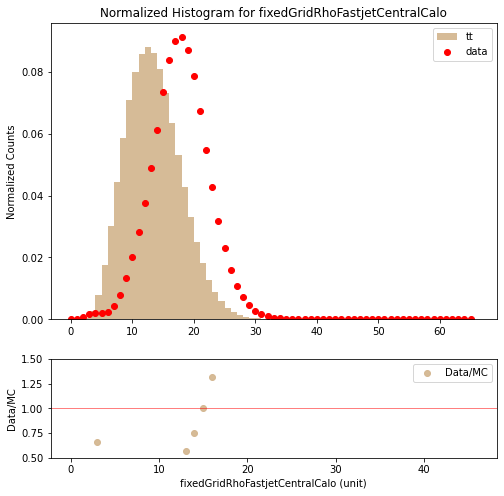

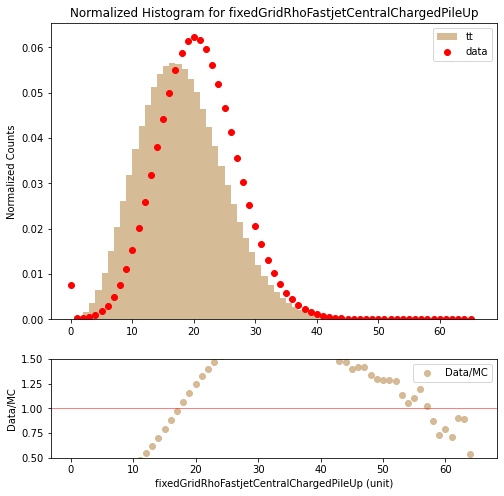

/tmp/ipykernel_83023/971152783.py:26: RuntimeWarning: divide by zero encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zg_hist, color='tan', label='Data/MC', alpha=0.9)


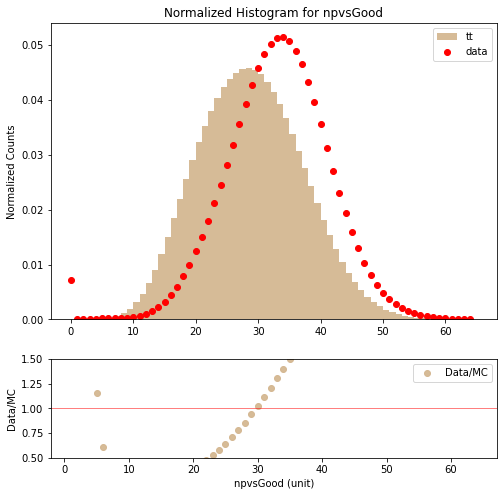

In [7]:
#无修正图
for group, variable in variables:
    plot_histogram(variable, combined_data, combined_zg)

/tmp/ipykernel_83023/1770918638.py:13: RuntimeWarning: divide by zero encountered in true_divide
  data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zg_hist_normalized)
/tmp/ipykernel_83023/1770918638.py:13: RuntimeWarning: invalid value encountered in true_divide
  data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zg_hist_normalized)
/tmp/ipykernel_83023/971152783.py:26: RuntimeWarning: divide by zero encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zg_hist, color='tan', label='Data/MC', alpha=0.9)
/tmp/ipykernel_83023/971152783.py:26: RuntimeWarning: invalid value encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zg_hist, color='tan', label='Data/MC', alpha=0.9)
/tmp/ipykernel_83023/971152783.py:39: RuntimeWarning: divide by zero encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zg_hist_weighted, color='cornflowerblue', label='Data/MC (weighted)', alpha=0.9)
/tmp/ipykernel_83023/971152783

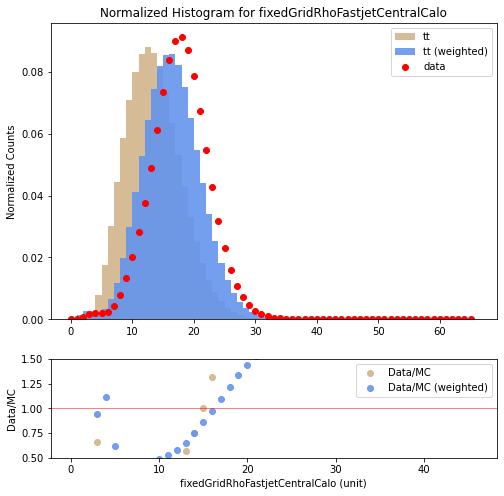

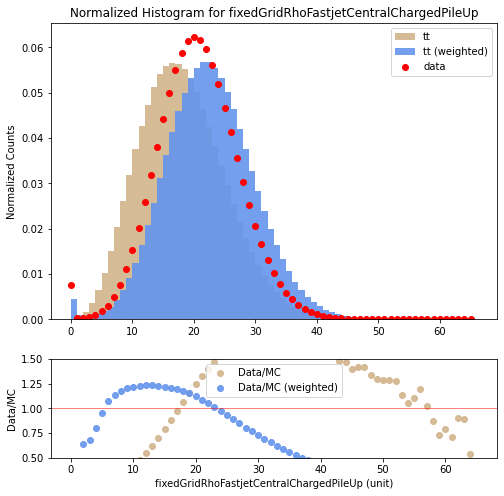

/tmp/ipykernel_83023/971152783.py:26: RuntimeWarning: divide by zero encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zg_hist, color='tan', label='Data/MC', alpha=0.9)
/tmp/ipykernel_83023/971152783.py:39: RuntimeWarning: divide by zero encountered in true_divide
  ax2.scatter(data_edges[:-1], data_hist / zg_hist_weighted, color='cornflowerblue', label='Data/MC (weighted)', alpha=0.9)


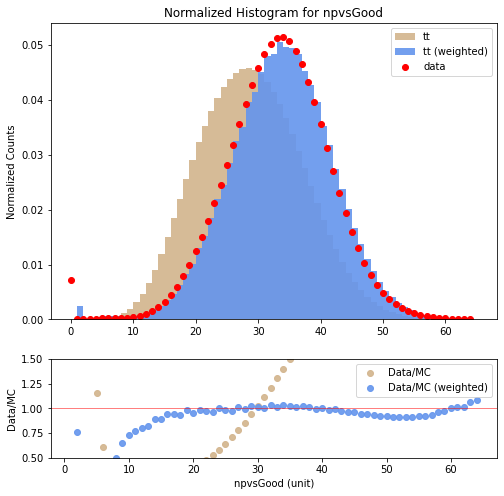

In [8]:
# 3. 计算三个变量的 Data/MC 比值
data_mc_ratios = {}
for group, variable in variables:
#    data_hist, data_edges = np.histogram(combined_data[variable], bins=50)
    data_hist, data_edges = np.histogram(combined_data[variable], bins=66)
    zg_hist, zg_edges = np.histogram(combined_zg[variable], bins=data_edges)
    
    # 归一化 data 和 zg 的直方图
    data_hist_normalized = data_hist / data_hist.sum()
    zg_hist_normalized = zg_hist / zg_hist.sum()
    
    # 计算归一化直方图的比值
    data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zg_hist_normalized)


# 4. 获取每个事件的综合pile-up权重
def get_weights(event_array, data_mc_ratios):
    pu_weights = []
    for variable, (bin_edges, ratio_values) in data_mc_ratios.items():
        bin_indices = np.digitize(event_array[variable], bin_edges) - 1
        pu_weights.append(ratio_values[bin_indices])
    return np.mean(np.array(pu_weights), axis=0)

pileup_weights = get_weights(combined_zg, data_mc_ratios)

# 5. 重新画出加权后的直方图
for group, variable in variables:
    plot_histogram(variable, combined_data, combined_zg, zg_weights=pileup_weights)




In [9]:
data_mc_ratios

{'fixedGridRhoFastjetCentralCalo': (array([ 0.        ,  0.80480385,  1.6096077 ,  2.4144115 ,  3.2192154 ,
          4.0240192 ,  4.828823  ,  5.633627  ,  6.438431  ,  7.2432346 ,
          8.0480385 ,  8.852842  ,  9.657646  , 10.46245   , 11.267254  ,
         12.072058  , 12.876862  , 13.681665  , 14.486469  , 15.291273  ,
         16.096077  , 16.90088   , 17.705685  , 18.510489  , 19.315292  ,
         20.120096  , 20.9249    , 21.729704  , 22.534508  , 23.339312  ,
         24.144115  , 24.94892   , 25.753723  , 26.558527  , 27.36333   ,
         28.168135  , 28.972939  , 29.777742  , 30.582546  , 31.38735   ,
         32.192154  , 32.996956  , 33.80176   , 34.606567  , 35.41137   ,
         36.21617   , 37.020977  , 37.825783  , 38.630585  , 39.435387  ,
         40.240192  , 41.045     , 41.8498    , 42.654602  , 43.459408  ,
         44.264214  , 45.069016  , 45.873817  , 46.678623  , 47.48343   ,
         48.28823   , 49.093033  , 49.89784   , 50.702644  , 51.507446  ,
    

In [42]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import awkward as ak
import os

In [43]:
# Convert your dictionary data to pandas dataframe
df = pd.DataFrame.from_dict({
    key: pd.Series(ak.to_list(value))
    for key, value in data_mc_ratios.items()
})

In [44]:
# Save dataframe to parquet
file_path = os.path.join("pileup_file", "data.parquet")
table = pa.Table.from_pandas(df)
pq.write_table(table, file_path)

In [13]:
# 获取每个事件的综合pile-up权重
def get_weights(event_final, sample, data_mc_ratios):
    pu_weights = []
    for variable, (bin_edges, ratio_values) in data_mc_ratios.items():
        if variable == 'npvsGood':
            array_key = 'npvsGood'
        elif variable == 'GridRhoFastjetCentralChargedPileUp':
            array_key = 'Rho_tracker'
        else:
            array_key = 'Rho_Calo'

        bin_indices = np.digitize(event_final[sample][array_key], bin_edges) - 1
        pu_weights.append(ratio_values[bin_indices])
    return np.mean(np.array(pu_weights), axis=0)

# 计算所有样本的pile-up权重
samples = ['zg', 'tt', 'zz', 'wz', 'ww']
all_pileup_weights = {}

for sample in samples:
    all_pileup_weights[sample] = get_weights(event_final, sample, data_mc_ratios)

# 打印权重
for sample, weights in all_pileup_weights.items():
    print(f"{sample}: {weights}")




zg: [1.13732457 1.13953578 1.2680693  ... 1.21378702 1.26240664 1.05210606]
tt: [0.85377484 0.78964663 1.05210606 ... 0.93504344 1.30874601 1.1711666 ]
zz: [0.8638046  0.57592047 1.14122518 1.0180449  0.97849641 1.13821401
 1.00440581 1.26898667 1.3076178  1.05686287 1.17861002 0.72696744
 0.6849229  1.22129141 1.23036011 0.96442694 0.77743123 1.10757411
 1.29620726 0.81324135 1.26929788 0.89923332 1.25683551 0.77743123
 1.09623222 1.3076178  1.20920936 1.21162435 1.00567627 1.21378702
 0.8638046  1.04110498 0.78964663 1.21378702 0.98140609 1.3076178
 1.13821401 1.21162435 1.26950872 1.26042491 1.2680693  0.8638046
 1.06486978 1.26042491 1.12254941 1.03327433 1.2695974  1.29620726
 1.10029849 0.90005495 0.66440484 1.3076178  1.07986801 1.03614794
 0.94731498 0.89961472 1.21728701 1.25333552 0.89570817 0.70851762
 1.10039251 0.96442694 0.95076619 1.02150672 1.29620726 1.26042491
 1.29651847]
wz: [1.29651847 1.29620726 1.09623222 ... 1.30730659 1.13984699 1.3076178 ]
ww: [1.10029849 1.26

/tmp/ipykernel_115175/2584002033.py:12: RuntimeWarning: divide by zero encountered in true_divide
  data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zz_hist_normalized)
/tmp/ipykernel_115175/2584002033.py:12: RuntimeWarning: invalid value encountered in true_divide
  data_mc_ratios[variable] = (data_edges[:-1], data_hist_normalized / zz_hist_normalized)


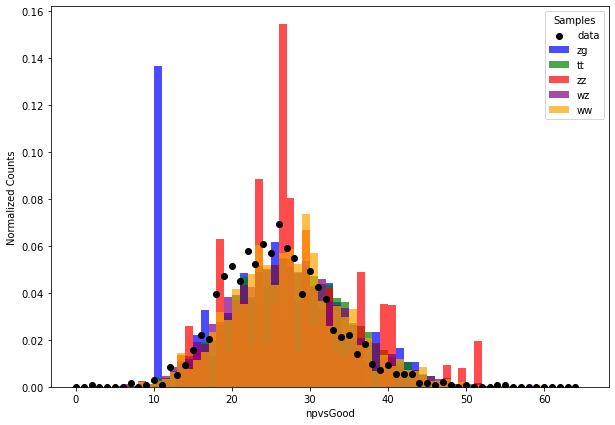

In [14]:
import matplotlib.pyplot as plt

def plot_weighted_npvsGood_histogram(event_final, all_pileup_weights):
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # 设置直方图参数
    bins = np.arange(0, 66, 1)
    alpha = 0.7
    
    # 绘制 data 散点图
    data_npvsGood = event_final['data']['npvsGood']
    data_hist, data_edges = np.histogram(data_npvsGood, bins=bins)
    data_hist_normalized = data_hist / data_hist.sum()
    plt.scatter(data_edges[:-1], data_hist_normalized, label='data', color='black', zorder=5)

    # 绘制经过 weight 后的样本的直方图
    samples = ['zg', 'tt', 'zz', 'wz', 'ww']
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for sample, color in zip(samples, colors):
        weighted_npvsGood = event_final[sample]['npvsGood']
        weights = all_pileup_weights[sample]
        hist, edges = np.histogram(weighted_npvsGood, bins=bins, weights=weights)
        hist_normalized = hist / hist.sum()
        plt.hist(edges[:-1], bins, weights=hist_normalized, alpha=alpha, label=sample, color=color)
    
    # 设置坐标轴标签和图例
    plt.xlabel("npvsGood")
    plt.ylabel("Normalized Counts")
    plt.legend(title='Samples', loc='upper right')
    
    # 显示图形
    plt.show()

plot_weighted_npvsGood_histogram(event_final, all_pileup_weights)
